# Assignment 4 - Lorenzo Pastore

In [0]:
def plot_acc(history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  t = f.suptitle('Deep Neural Net Performance', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epochs = list(range(1,10+1))
  ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
  ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
  ax1.set_xticks(epochs)
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')
  l1 = ax1.legend(loc="best")

  ax2.plot(epochs, history.history['loss'], label='Train Loss')
  ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
  ax2.set_xticks(epochs)
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  l2 = ax2.legend(loc="best")

### STL-10 load

In [2]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import tensorflow as tf
from google.colab import files
files.upload()
import stl10_input

tf.python.control_flow_ops = tf

nb_train_samples = 5000
nb_validation_samples = 8000
nb_epoch = 50
nb_classes = 10

Using TensorFlow backend.


Saving stl10_input.py to stl10_input (4).py
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [3]:
(X_train, y_train), (X_test, y_test) = stl10_input.load_data()
Y_train = np_utils.to_categorical(y_train-1, nb_classes)
Y_test = np_utils.to_categorical(y_test-1, nb_classes)

(5000, 96, 96, 3)
(5000,)
(8000, 96, 96, 3)
(8000,)


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

#validation split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                                  Y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(Y_train), 
                                                  random_state=42)

In [0]:
#Y_train = np_utils.to_categorical(y_train-1, nb_classes)
#Y_val = np_utils.to_categorical(y_val-1, nb_classes)
#Y_test = np_utils.to_categorical(y_test-1, nb_classes)

Train data: (4250, 96, 96, 3)
Train labels: (4250, 10)
Test data: (8000, 96, 96, 3)
Test labels: (8000, 10)
Validation data: (750, 96, 96, 3)
Validation labels: (750, 10)


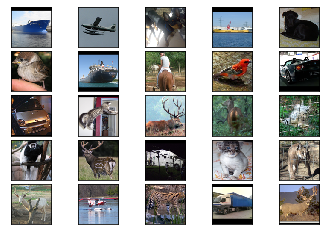

In [6]:
print("Train data:",X_train.shape)
print("Train labels:",Y_train.shape)
print("Test data:",X_test.shape)
print("Test labels:",Y_test.shape)
print("Validation data:",X_val.shape)
print("Validation labels:",Y_val.shape)

import matplotlib.pyplot as plt
# display some random training images in a 25x25 grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, X_train.shape[0])
        ax[m, n].imshow(X_train[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

### STL-10 Preprocessing and data augmentation

In [0]:
#Training Set data Augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=32,
                                     seed=100)

In [0]:
#Training Set data Augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=32,
                                 seed=100)

In [0]:
#Training Set data Augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow(X_test,
                                   Y_test,
                                   batch_size=32,
                                   seed=100)

### Create and compile VGG16 model

In [10]:
tf.python.control_flow_ops = tf

img_width, img_height = 96, 96
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(img_width, img_height, 3)
                  )
base_model.summary()











Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)   

In [0]:
#Congelamento del modello di base
for layer in base_model.layers:
    layer.trainable = False

# Model A

In [12]:
from keras.layers import  GlobalAveragePooling2D, BatchNormalization

xa = base_model.get_layer('block2_pool').output
# Add classification layers on top of it
xa = GlobalAveragePooling2D()(xa)
xa = BatchNormalization()(xa)
xa = Dense(512, activation='relu')(xa)
xa = Dropout(0.2)(xa)
xa = Dense(256, activation='relu')(xa)
xa = Dropout(0.2)(xa)
pred_a = Dense(nb_classes, activation='softmax')(xa)
a_model = Model(inputs=base_model.input, outputs=pred_a)

a_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [13]:
train_steps_per_epoch = X_train.shape[0] // 32
val_steps_per_epoch = X_val.shape[0] // 32
epochs = 10
a_history = a_model.fit_generator(train_generator,
                                  steps_per_epoch=train_steps_per_epoch,
                                  validation_data=val_generator,
                                  validation_steps=val_steps_per_epoch,
                                  epochs=epochs,
                                  verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
132/132 [==============================] - 15s 112ms/step - loss: 1.6800 - acc: 0.3661 - val_loss: 1.3605 - val_acc: 0.5258
Epoch 2/10
132/132 [==============================] - 13s 101ms/step - loss: 1.4433 - acc: 0.4709 - val_loss: 1.3268 - val_acc: 0.5237
Epoch 3/10
132/132 [==============================] - 14s 102ms/step - loss: 1.3475 - acc: 0.4985 - val_loss: 1.2762 - val_acc: 0.5320
Epoch 4/10
132/132 [==============================] - 13s 100ms/step - loss: 1.3144 - acc: 0.5119 - val_loss: 1.2667 - val_acc: 0.5501
Epoch 5/10
132/132 [==============================] - 13s 98ms/step - loss: 1.2621 - acc: 0.5440 - val_loss: 1.1558 - val_acc: 0.5571
Epoch 6/10
132/132 [==============================] - 13s 99ms/step - loss: 1.2376 - acc: 0.5472 - val_loss: 1.1718 - val_acc: 0.5641
Epoch 7/10
132/132 [==============================] - 13s 96ms/step - loss: 1.1804 - acc: 0.5625

In [0]:
result_a = a_model.evaluate_generator(test_generator)

# Model B

In [0]:
# Add classification layers on top of it
xb = base_model.get_layer('block3_pool').output
# Add classification layers on top of it
xb = GlobalAveragePooling2D()(xb)
xb = BatchNormalization()(xb)
xb = Dense(512, activation='relu')(xb)
xb = Dropout(0.2)(xb)
xb = Dense(256, activation='relu')(xb)
xb = Dropout(0.2)(xb)
pred_b = Dense(nb_classes, activation='softmax')(xb)
b_model = Model(inputs=base_model.input, outputs=pred_b)

b_model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [16]:
b_history = b_model.fit_generator(train_generator,
                                  steps_per_epoch=train_steps_per_epoch,
                                  validation_data=val_generator,
                                  validation_steps=val_steps_per_epoch,
                                  epochs=epochs,
                                  verbose=1)

Epoch 1/10
132/132 [==============================] - 14s 106ms/step - loss: 1.3778 - acc: 0.4985 - val_loss: 0.9428 - val_acc: 0.6739
Epoch 2/10
132/132 [==============================] - 14s 104ms/step - loss: 1.0611 - acc: 0.6104 - val_loss: 0.9108 - val_acc: 0.6685
Epoch 3/10
132/132 [==============================] - 14s 105ms/step - loss: 0.9524 - acc: 0.6558 - val_loss: 0.8539 - val_acc: 0.7047
Epoch 4/10
132/132 [==============================] - 14s 104ms/step - loss: 0.8795 - acc: 0.6814 - val_loss: 0.7919 - val_acc: 0.7047
Epoch 5/10
132/132 [==============================] - 13s 102ms/step - loss: 0.8368 - acc: 0.6986 - val_loss: 0.8077 - val_acc: 0.7326
Epoch 6/10
132/132 [==============================] - 13s 100ms/step - loss: 0.7784 - acc: 0.7117 - val_loss: 0.8460 - val_acc: 0.7131
Epoch 7/10
132/132 [==============================] - 13s 100ms/step - loss: 0.7755 - acc: 0.7127 - val_loss: 0.7131 - val_acc: 0.7326
Epoch 8/10
132/132 [==============================] - 1

In [0]:
result_b = b_model.evaluate_generator(test_generator)

# Model C

In [0]:
xc = base_model.get_layer('block4_pool').output
# Add classification layers on top of it
xc = GlobalAveragePooling2D()(xc)
xc = BatchNormalization()(xc)
xc = Dense(512, activation='relu')(xc)
xc = Dropout(0.2)(xc)
xc = Dense(256, activation='relu')(xc)
xc = Dropout(0.2)(xc)
pred_c = Dense(nb_classes, activation='softmax')(xc)
c_model = Model(inputs=base_model.input, outputs=pred_c)

c_model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
c_history = c_model.fit_generator(train_generator,
                                  steps_per_epoch=train_steps_per_epoch,
                                  validation_data=val_generator,
                                  validation_steps=val_steps_per_epoch,
                                  epochs=epochs,
                                  verbose=1)

Epoch 1/10
132/132 [==============================] - 15s 115ms/step - loss: 0.9935 - acc: 0.6549 - val_loss: 0.6453 - val_acc: 0.7663
Epoch 2/10
132/132 [==============================] - 14s 109ms/step - loss: 0.6544 - acc: 0.7700 - val_loss: 0.5838 - val_acc: 0.8036
Epoch 3/10
132/132 [==============================] - 14s 107ms/step - loss: 0.5488 - acc: 0.7978 - val_loss: 0.5003 - val_acc: 0.8189
Epoch 4/10
132/132 [==============================] - 14s 107ms/step - loss: 0.4604 - acc: 0.8377 - val_loss: 0.4846 - val_acc: 0.8189
Epoch 5/10
132/132 [==============================] - 14s 105ms/step - loss: 0.4352 - acc: 0.8429 - val_loss: 0.5330 - val_acc: 0.8120
Epoch 6/10
132/132 [==============================] - 14s 104ms/step - loss: 0.3697 - acc: 0.8644 - val_loss: 0.4375 - val_acc: 0.8343
Epoch 7/10
132/132 [==============================] - 14s 107ms/step - loss: 0.3630 - acc: 0.8708 - val_loss: 0.4537 - val_acc: 0.8301
Epoch 8/10
132/132 [==============================] - 1

In [0]:
result_c = c_model.evaluate_generator(test_generator)

# Model D

In [0]:
xd = base_model.get_layer('block5_pool').output
# Add classification layers on top of it
xd = GlobalAveragePooling2D()(xd)
xd = BatchNormalization()(xd)
xd = Dense(512, activation='relu')(xd)
xd = Dropout(0.2)(xd)
xd = Dense(256, activation='relu')(xd)
xd = Dropout(0.2)(xd)
pred_d = Dense(nb_classes, activation='softmax')(xd)
d_model = Model(inputs=base_model.input, outputs=pred_d)

d_model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['accuracy'])

In [22]:
d_history = d_model.fit_generator(train_generator,
                                  steps_per_epoch=train_steps_per_epoch,
                                  validation_data=val_generator,
                                  validation_steps=val_steps_per_epoch,
                                  epochs=epochs,
                                  verbose=1)

Epoch 1/10
132/132 [==============================] - 15s 114ms/step - loss: 0.8301 - acc: 0.7136 - val_loss: 0.4543 - val_acc: 0.8451
Epoch 2/10
132/132 [==============================] - 14s 109ms/step - loss: 0.5156 - acc: 0.8229 - val_loss: 0.4810 - val_acc: 0.8273
Epoch 3/10
132/132 [==============================] - 15s 113ms/step - loss: 0.4128 - acc: 0.8567 - val_loss: 0.4455 - val_acc: 0.8538
Epoch 4/10
132/132 [==============================] - 15s 110ms/step - loss: 0.3610 - acc: 0.8725 - val_loss: 0.3831 - val_acc: 0.8788
Epoch 5/10
132/132 [==============================] - 14s 109ms/step - loss: 0.3287 - acc: 0.8844 - val_loss: 0.4752 - val_acc: 0.8259
Epoch 6/10
132/132 [==============================] - 15s 110ms/step - loss: 0.3009 - acc: 0.8899 - val_loss: 0.4239 - val_acc: 0.8607
Epoch 7/10
132/132 [==============================] - 15s 112ms/step - loss: 0.2936 - acc: 0.8950 - val_loss: 0.4403 - val_acc: 0.8426
Epoch 8/10
132/132 [==============================] - 1

In [0]:
result_d = d_model.evaluate_generator(test_generator)

# Results VIZ

## Model A 

[1.1408927793502808, 0.579375]


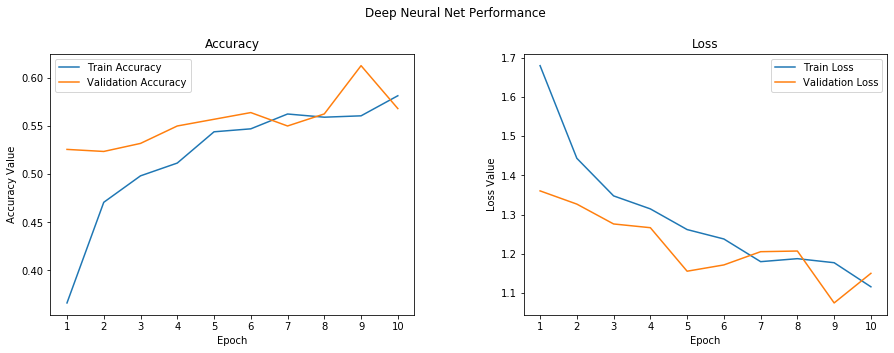

In [24]:
plot_acc(a_history)
print(result_a)

## Model B

[0.7992461088895798, 0.713375]


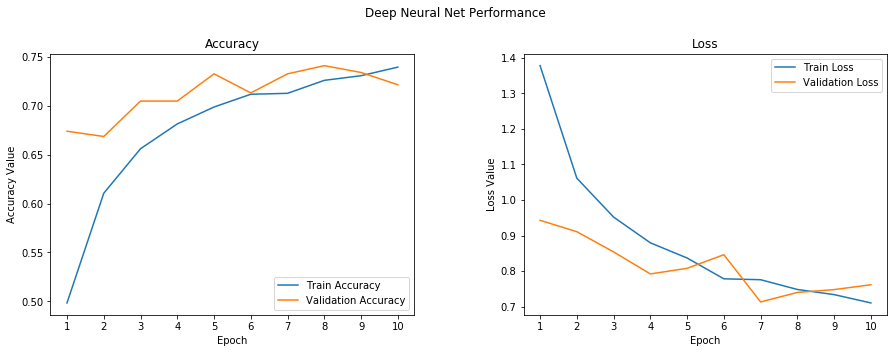

In [25]:
plot_acc(b_history)
print(result_b)

## Model C

[0.5187643277049064, 0.834625]


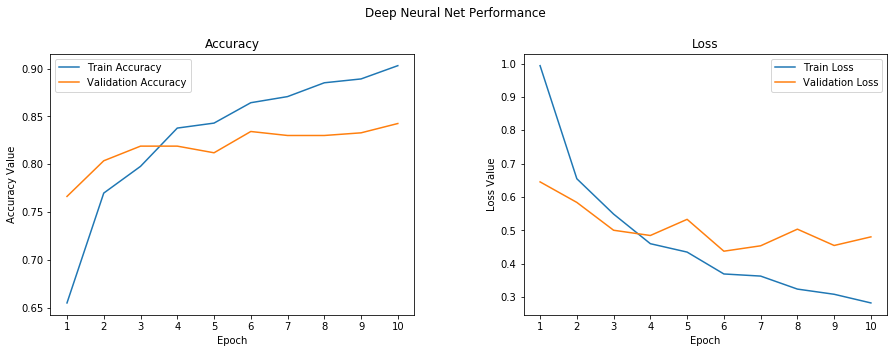

In [26]:
plot_acc(c_history)
print(result_c)

## Model D

[0.45289224272966383, 0.853375]


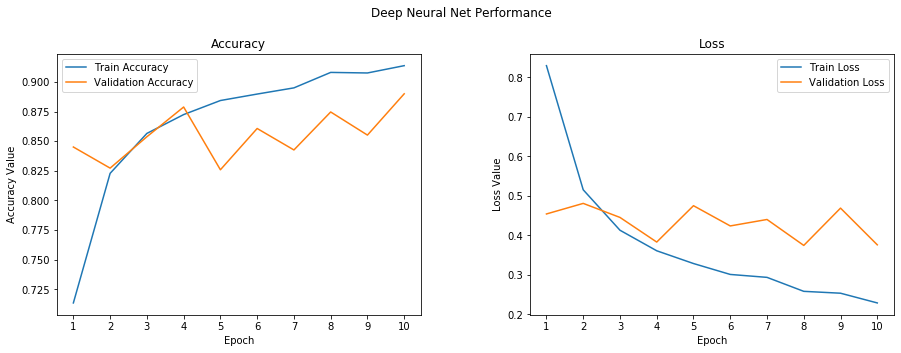

In [27]:
plot_acc(d_history)
print(result_d)